In [1]:
from __future__ import print_function, division
from builtins import range

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [3]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 50

In [4]:
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip

# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../content/drive/MyDrive/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  #/content/drive/MyDrive/glove.6B
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [5]:
train = pd.read_csv("../content/drive/MyDrive/nlu_dct_fix1.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["locate_restaurant", "restaurant_type", "table_reservation", "restaurant_review"]
targets = train[possible_labels].values

In [6]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
#print("sequences:", sequences); exit()

In [7]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 15
min sequence length: 1
median sequence length: 4
max word index: 198


In [8]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 198 unique tokens.


In [9]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (100, 100)


In [10]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [11]:
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [12]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)


print('Building model...')

Building model...


In [13]:
# train a 1D convnet with global maxpooling
#input_ = Input(shape=(MAX_SEQUENCE_LENGTH,1))
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
#x = Conv1D(128, 3, activation='relu')(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

#model = tf.keras.models.Model(input_, output)
model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)
model.summary()

print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          19900     
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 128)            49280 

In [14]:
print(data)
print(targets)

[[  0   0   0 ...   3  31   1]
 [  0   0   0 ...  10  15   4]
 [  0   0   0 ...  26  33   1]
 ...
 [  0   0   0 ...  11 189  14]
 [  0   0   0 ... 191   5  61]
 [  0   0   0 ... 197 198  35]]
[[1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 1

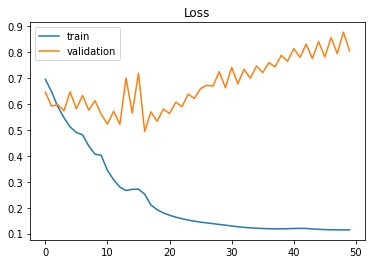

In [17]:
# plot some data
plt.plot(r.history['loss'], label='train')
plt.plot(r.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()
plt.show()

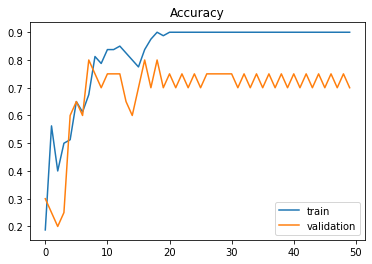

In [18]:
# accuracies
plt.plot(r.history['accuracy'], label='train')
plt.plot(r.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()
plt.show()

In [19]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(4):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.928636013825399


In [20]:
"""
from sklearn.metrics import classification_report
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
"""

In [21]:
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
"""

In [22]:
"""
X = targets
y = sentences
#class_names = possible_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
"""

NameError: ignored

In [23]:
"""
y_predict = y.predict(X_test, batch_size=None, verbose=0, steps=None)

y_pred = convert_to_labels(y_predict)
y_true = convert_to_labels(y_test)
target_names = [ "locate_restaurant", "restaurant_type", "table_reservation", "restaurant_review"]
print(classification_report(y_true, y_pred, target_names=target_names))
print ("**************************************************************")

plt.figure()
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True,
                    title='confusion matrix')

plt.show()
"""

AttributeError: ignored

In [24]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

In [25]:
X = targets
y = sentences
class_names = possible_labels

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Confusion matrix, without normalization
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0

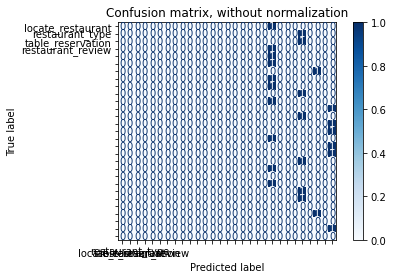

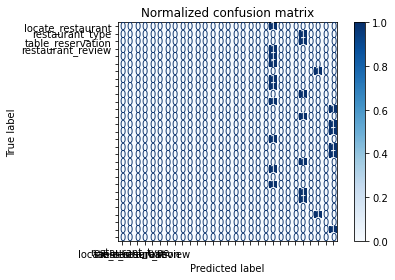

<Figure size 72000x72000 with 0 Axes>

In [26]:
X = targets
y = sentences
class_names = possible_labels

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                  display_labels=class_names,
                                  cmap=plt.cm.Blues,
                                  normalize=normalize)
    disp.ax_.set_title(title)
    
    print(title)
    print(disp.confusion_matrix)

plt.tight_layout()
plt.figure(figsize=(1000,1000))
plt.show()